# TME 7 : Détection d'objets simples (II) :

> Consignes: le fichier TME7_Sujet.ipynb est à déposer sur le site Moodle de l'UE https://moodle-sciences.upmc.fr/moodle-2018/course/view.php?id=4650. Si vous êtes en binôme, renommez-le en TME7_nom1_nom2.ipynb.

N'oubliez pas de sauvegarder fréquemment votre notebook !! ...

Pour chaque questions, écrivez des commentaires brefs et concis lorsque demandé dans les cases **Commentaires**.

In [2]:
### Chargement des modules et des données utiles.

from PIL import Image
from pylab import *
from scipy.signal import convolve2d
from skimage import morphology
from time import process_time

### charger les images et les convertir en tableaux Numpy
rectangle = array(Image.open("images/rectangle.png"))/255

carrelage = array(Image.open("images/carrelage_wikipedia.jpg"))/255
jussieu = array(Image.open("images/Jussieu_wikipedia.jpg"))/255
house = array(Image.open("images/house2.jpg"))/255
#rotate = array(Image.open("images/rotate.png"))
table = array(Image.open("images/table.png"))/255
chaise = array(Image.open("images/chaise.png"))/255

### image synthétique pour mise au point
def image_contours_ligne_simple():
    """ NoneType -> Array
    Construit une image de contours seuillée de taille 500x500 avec une ligne.
    """
    image_contours = zeros((500,500))
    for t in range(200):
        image_contours[ t + 100, t] = 1
    return image_contours

### Fonctions d'affichage
def affichage_14(affichages,titres=None):
    """ list[Array]*list[str] -> NoneType
    Dffectue entre 1 et 4 affichages avec leurs titres, pour des images ou courbes
    
    Paramètres :
      - liste des affichages (entre 1 et 4)
      - liste des titres (entre 1 et 4, autant que de affichages), optionnelle    
    """
    
    if not type(affichages) == type([]):
        affichages = [affichages]
        
    if titres is None:
        titres = ['',]*len(affichages)
        
    if not type(titres) == type([]):
        titres = [titres]
    
    nb_affichages = len(affichages)
    if nb_affichages >4 or nb_affichages < 1 :
        raise ValueError('affichage_14 nécéssite 1 à 4 entrées en paramètre')        
        
    if nb_affichages != len(titres):
        raise ValueError('affichage_14 nécéssite autant de titres que d\'affichages')
        
    courbes = False
    for i in range(0,nb_affichages):
        s = subplot(101+10*nb_affichages+i)
        s.set_title(titres[i])
        if len(affichages[i].shape)==2 and affichages[i].shape[0] > 1 and affichages[i].shape[1] > 1:
            # on affiche une image
            s.imshow(affichages[i], cmap="gray",interpolation='nearest', aspect='equal')
        else :
            # il s'agit d'une seule ligne, à afficher comme une courbe
            plot(affichages[i])
            courbes=True

    agrandissement_h = nb_affichages
    agrandissement_v = nb_affichages*2 if courbes else nb_affichages
    params = gcf()
    plSize = params.get_size_inches()
    params.set_size_inches( (plSize[0]*agrandissement_v, plSize[1]*agrandissement_h) )
    show()


def trace_image_et_cercles(image, liste_cercles):
    """
    Array*list[tuple(int,int,int)] -> NoneType
    Affichage supperposé d'une image et de cercles.
    """
    fig, ax = subplots()
    imshow(image, cmap=cm.gray)
    for cercle in liste_cercles:
        rayon = cercle[0]
        X_c = cercle[2]
        Y_c = cercle[1]
        circle1 = Circle((X_c, Y_c),rayon,color='r', fill=False)
        gcf().gca().add_artist(circle1)
        
    set_xlim((0, image.shape[1]))
    set_ylim((image.shape[0], 0))
    set_axis_off()
    set_title('Cercles détectés')
    show()

### Fonctions de chronométrage
mytime = 0
def tic():
    global mytime
    mytime = process_time()
def tac():
    global mytime
    print (process_time()-mytime)
    mytime = process_time()


## Exercice 1 — Transformée de Hough: détection de droites

### Question 1 : Calcul de l'accumulateur à partir d'une image de contours, version boucle

On dispose d'une image de contours binarisée. On cherche à calculer la transformée de Hough correspondant.

1. Écrire la fonction ```houghl()``` qui renvoie la transformée de Hough pour les droites de l'image de contours binarisée. On utilisera l'algorithme données en TD. 

La fonction prendra pour arguments:
- l'image de contours: adges, 
- le nombre de pas pour $\theta$: ``ntheta``,
- le nombre de pas pour $\rho$: ``nrho``,
- la tolérance: ``tol`` (qui correspond au test $|x\cos\theta+y\sin\theta-\rho|<tol$).

**Conseil 1:** remplacer le parcours de l'image par une boucle sur les tableaux d'indices ``X`` et ``Y`` des valeurs non nulles de l'image. On utilisera pour cela la fonction Numpy ```nonzero()``` et la fonction Python ```zip()```. 

**Conseil 2:** le calcul des cosinus et sinus est coûteux. En remarquant que les 4 boucles imbriquées sont indépendantes les unes des autres et qu'on peut les permuter,  faire en sorte de ne calculer **qu'une seule fois** les valeurs cosinus et sinus pour chaque élément de l'accumulateur de Hough.

In [2]:
def houghl(I,ntheta,nrho,tol):
    """ Array*int*int*float -> Array[int] """
    #tab_I = np.array(I)
    #zip_I = zip(tab_I.nonzero())
    h,w = I.shape
    rmax = (h**2+w**2)**0.5
    
    tab_acc = np.zeros([nrho,ntheta] ,dtype = np.int)
    
    xnz, ynz = I.nonzero()
    
    for rho in range(nrho):
        for theta in range(ntheta):
            for i in range(len(xnz)):
                
                p = rho*(rmax/nrho)
                o = -pi/2 + theta*((3*pi)/(2*ntheta))
                
                if abs(xnz[i]*cos(o)+ynz[i]*sin(o)-p)<tol:
                    tab_acc[rho,theta] += 1
    return tab_acc

"""
def appartient_droite(x,y,theta,rho,tol):
    if abs(x*cos(theta)+y*sin(theta)-rho)<tol:
        return 1
    return 0
"""

'\ndef appartient_droite(x,y,theta,rho,tol):\n    if abs(x*cos(theta)+y*sin(theta)-rho)<tol:\n        return 1\n    return 0\n'

2. Tester la fonction ```houghl()``` en l'appliquant à l'image de contours binarisée synthétique très simple générée par la fonction ```image_contours_ligne_simple()```. Afficher l'accumulateur de Hough. Chronométrez également le temps de calcul de la fonction ```hough()```, en prenant des valeurs différentes pour nt et nr. Rappel TD: idéalement nr vaut la longueur d'une diagonale de l'image à traiter et nt pourrait valoir 360 pour avoir une précision de 1 degré, dans un repère polaire. Conseil: essayer d'abord avec des valeurs nettement plus petites, puis augementer les et observer les temps de calcul. Donner un ordre de grandeur de la complexité de cet algorithme.

10.773932218


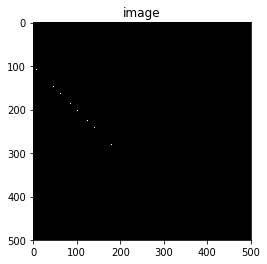

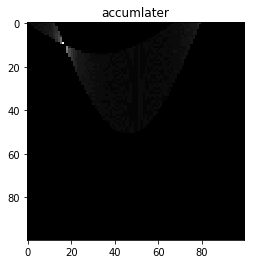

In [3]:
img = image_contours_ligne_simple()
tic()
acc1 = houghl(img,100,100,1)
tac()
affichage_14(img,titres="image")
affichage_14(acc1,titres="accumlater")

### Question 2: optimisation de la fonction ``houghl()``

Vous avez du constater que le temps de calcul est très long et cela même pour une image très simple. Le temps dépend donc largement des valeurs ```ntheta``` et ```nrho```.
Puisque les 4 boucles de l'algorithme (boucles sur indice de ligne, de colonne de l'image de contours à traiter, d'angle et de distance à l'origine) sont indépendantes, on peut imbriquer les parcours sur l'image à l'intérieur du parcours de l'accumulateur de Hough.

On pourra alors constater qu'il revient au même de calculer à l'avance les différentes valeurs de $\rho$ et $\theta$ et de les placer dans des tableaux. En effet, écrire :
````
for r in range(nrho):
    for t in range(ntheta):
       calcul sur t, indépendemment de r
       calcul sur r, indépendemment de t
````
revient à écrire:
`````
for r in range(nrho):
    for t in range(ntheta):
        CT[r,t] = f(t)
        CR[r,t] = g(r)
`````
Le calcul des tableaux ``CT`` et ``CR`` peut-être effectué uniquement par appel Numpy **sans utiliser de boucle**: le tableau ``CT`` voit chacune de ses colonnes **identiques** et ``CR`` ses lignes **identiques**. 

1. En utilisant à bon escient les fonctions ``ones()`` et ```linspace()```, puis facultativement ```meshgrid()```, ou encore plus simplement en gardant les boucles, construire les tableaux ```R```, ```C``` et ```S```. Chaque ligne du tableau ```R``` décrit les mêmes suites de valeurs de $\rho$. Chaque colonne des tableaux ```C``` et ```S``` décrivent les mêmes suites de valeurs de $\cos\theta$ et $\sin\theta$. On rappelle que $\rho$ et $\theta$ vérifient l'équation $x\cos\theta + y\sin\theta = \rho$  pour $x$ et $y$ les coordonnées d'un point de contours dans l'image. Pour la version boucle, quelle est la complexité ? Est-elle acceptable pour un script Python ?

In [4]:
# pour tester
nrho,ntheta = 4,6
n,m = 50,50

rmax = (n**2+m**2)**0.5

R = linspace(0,rmax,nrho)
T = linspace(-pi/2,pi,ntheta)
C = ones(len(T))
S = ones(len(T))

for i in range(len(T)):
    C[i] = cos(T[i])
    S[i] = sin(T[i])
    
print(R)
print(T)
print(C)
print(S)



[ 0.         23.57022604 47.14045208 70.71067812]
[-1.57079633 -0.62831853  0.31415927  1.25663706  2.19911486  3.14159265]
[ 6.12323400e-17  8.09016994e-01  9.51056516e-01  3.09016994e-01
 -5.87785252e-01 -1.00000000e+00]
[-1.00000000e+00 -5.87785252e-01  3.09016994e-01  9.51056516e-01
  8.09016994e-01  1.22464680e-16]


2. Soit $(x_1,y_1),..,(x_n,y_n)$ la liste des $n$ points de contours dans l'image de contours binarisée que l'on doit analyser, remarquer alors que $H = \sum_{i=1}^n |x_i C + y_i S - R| <= tol$. En déduire une version 2 de la fonction ``houghl_opt()``. Comparer le temps d'exécution avec la version précédente. 

7.488886836000001


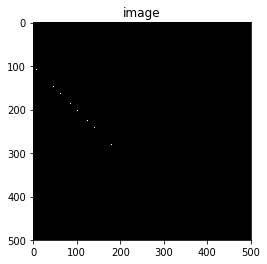

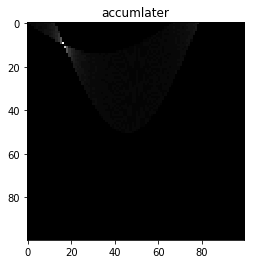

In [5]:
def houghl_opt(edges,ntheta,nrho,tol):
    """ Array*int*int*float -> Array[int] """
    #tab_I = np.array(I)
    #zip_I = zip(tab_I.nonzero())
    h,w = edges.shape
    rmax = (h**2+w**2)**0.5

    xnz, ynz = edges.nonzero()
    
    R = linspace(0,rmax,nrho)
    T = linspace(-pi/2,pi,ntheta)
    C = ones(len(T))
    S = ones(len(T))

    for i in range(len(T)):
        C[i] = cos(T[i])
        S[i] = sin(T[i])
        
    tab_acc = np.zeros([len(R),len(T)] ,dtype = np.int)    
    
    
    for i in range(len(R)):
        for j in range(len(T)):
            for n in range(len(xnz)):
                if abs(xnz[n]*C[j]+ynz[n]*S[j]-R[i])<=tol:
                    tab_acc[i,j] += 1
    return tab_acc

#test

tic()
acc = houghl_opt(image_contours_ligne_simple(),100,100,1)
tac()
affichage_14(image_contours_ligne_simple(),titres="image")
affichage_14(acc,titres="accumlater")

### Question 3 : Recherche des $N$ plus grands maxima locaux

On cherche ici à rechercher les $N$ plus grands maxima locaux de l'accumulateur de Hough afin de déterminer quelles sont les droites détectées.

1. Écrire une fonction ```maxloc_N(H,N)``` qui calcule les ``N`` maxima locaux de l'accumulateur ``H``. La fonction est similaire à celle du TME 6 (```maxloc()```) avec une différence toutefois : elle retourne une liste des coordonnées des ``N`` premiers maxima locaux **trié** par valeurs décroissantes qu'ils prennent dans ```H```. On rappelle que Python possède une fonction ```sorted()``` opérant sur les listes.

In [19]:
def maxloc_N(H, N): 
    """ Array[int]*int -> list[tuple(int,int)] """
    temp = []
    res = [0]*N
    rho,theta = H.shape
    for i in range(1,rho-1):
        for j in range(1,theta-1):
            if sum(H[i-1:i+2,j-1:j+2]-H[i,j]>=0)==1 :
                temp.append((H[i,j],(i,j)))
                                    
    temp.sort(key=lambda k:k[0],reverse=True)
    #print(temp)
    #print(len(temp))
    #print(len(res))
    for cpt in range(len(res)):
        res[cpt]=(temp[cpt])[1];

    return res;



In [20]:

print(acc[4:7,13:16])
print(acc[6,14])

[[ 8  7  0]
 [ 9 12  0]
 [ 8 12  0]]
12


2. Tester cette fonction sur l'accumulateur calculé à la question 1 (ou 2).

In [21]:
#(rho,theta)
print(maxloc_N(acc, 10))

[(9, 16), (11, 17), (3, 13), (2, 77), (22, 22), (2, 67), (4, 67), (16, 30), (18, 30), (25, 30)]


3. Écrire une fonction ``hougl_intersect(l,c,H,I)`` qui calcule l'intersection de la droite de coordonnée ``(l,c)`` dans l'accumulateur ``H`` avec les bords de l'image ``I``. La fonction doit calculer les valeurs $(\rho,\theta)$ correspondant à ``(l,c)`` puis calculer une liste de 4 coordonnées qui correspond aux intersections de la droite  $(\rho,\theta)$ avec les droites $x=0$, $x=m-1$, $y=0$ et $y=m-1$ dans le plan image. La fonction ne retournera que les intersections qui sont dans le plan de l'image (normalement 2) sous forme de deux listes: la première liste donc les indices de colonne, et la seconde, les indices de ligne.

In [9]:
def houghl_intersect(l,c,H,I):
    """ int*int*Array[int]*Array -> tuple[list[int],list[int]] """
    w,h = I.shape
    
    ntheta,nrho = H.shape
    
    rmax = (h**2+w**2)**0.5
    
    rho = l*(rmax/nrho)
    theta = -pi/2 + (ntheta-c)*((3*pi)/(2*ntheta))
    
    x1 = 0
    y1 = ((rho-x1*cos(theta))/sin(theta))
    
    x2 = w-1
    y2 = ((rho-x2*cos(theta))/sin(theta))
    
    y3 = 0
    x3 = (rho-y3*sin(theta))/cos(theta)
    
    y4 = h-1
    x4 = (rho-y4*sin(theta))/cos(theta)
    
    coodx = [x1,x2,x3,x4]
    coody = [y1,y2,y3,y4]
    
    return (coodx,coody)

I = zeros([500,500] ,dtype = np.int)
print(houghl_intersect(20,30,acc,I))

([0, 499, -904.0294042680407, 2246.532601554807], [143.18419123191754, 222.2180269538611, 0, 499])


4. Écrire une fonction ``houghl_draw(H,N,I)`` qui affiche l'image ``I`` et les ``N`` segments de droites correspondant aux $N$ premiers maxima locaux de $H$. Testez là sur l'accumulateur précédent. Si le résultat n'est pas très précis, recalculer l'accumulateur de Hough avec plus de précision.

[(60, (9, 16)), (45, (11, 17)), (9, (3, 13)), (6, (2, 77)), (6, (22, 22)), (3, (2, 67)), (3, (4, 67)), (3, (16, 30)), (3, (18, 30)), (3, (25, 30)), (3, (30, 30)), (3, (32, 30))]
12
[0, 499, -87.30089048125757, 381.29129992167134]
[92.96600592657943, 624.3470342486503, 0, 499]


/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


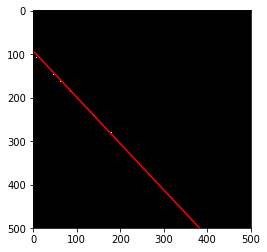

In [10]:
def  houghl_draw(H,N,I):
    """ Array[int]*int*Array -> NoneType"""
    w,h = I.shape
    maxL = maxloc_N(H,N)
    for point in maxL:
        lx,ly = houghl_intersect(point[0],point[1],H,I)
        print(lx)
        print(ly)
        theta = np.linspace(lx[0],lx[1])
        rho = np.linspace(ly[0],ly[1])
        plt.plot(theta,rho,color = 'red')
        return I
    
affichage_14(houghl_draw(acc,5,img))

### Question 4 : Détection de lignes sur une image.

On cherche maintenant à détecter les lignes dans une image quelconque à l'aide de la méthode de Hough.

1. Écrire une fonction ``edges(I,s)`` qui réalise une détection de contours sur l'image ``I`` à l'aide des opérateurs de Sobel et de la fonction ``convolve2d()``. On effectuera un seuillage binaire sur la norme du gradient, le seuil sera donné par ``s``. Enfin, on utilisera la fonction ```morphology.thin()``` du module ``skimage`` qui permet de réalisé un affinage des contours. La fonction retournera la carte des contours affinés.



In [11]:
def edges(I,s):
    """ Array*float -> Array[bool] """
    sobelx = array([[-1,0,1],[-2,0,2],[-1,0,1]])
    sobely = array([[-1,-2,-1],[0,0,0],[1,2,1]])
    norm=(convolve2d(I,sobelx)**2+convolve2d(I,sobely)**2)**0.5
    thresh=norm>s
    res=morphology.thin(thresh)
    return res
    


2. Tester la fonction ``edges()`` sur l'image ``rectangle.png``. Afficher l'image des contours binarisée.

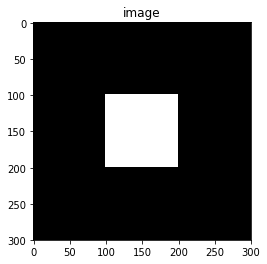

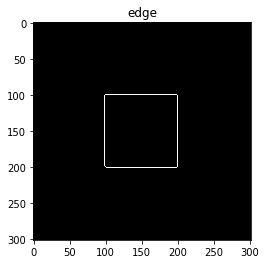

In [12]:
img_rec = np.array(Image.open("images/rectangle.png"))
edge = edges(rectangle,2)

affichage_14(img_rec,titres="image")
affichage_14(edge,titres="edge")

3. Calculer et afficher l''accumulateur de Hough pour cette image. On utilisera la version optimisée du détecteur de Hough ainsi que les valeurs ntheta=360 et nrho = longueur diagonale de l'image. Commenter l'aspect de l'accumulateur.

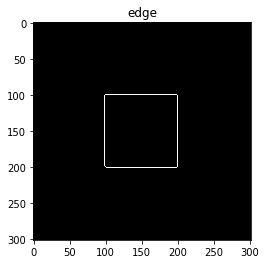

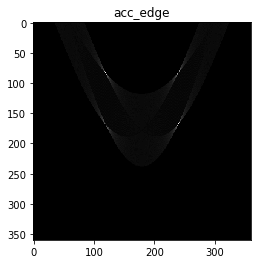

In [15]:
h,w = img_rec.shape
#nrho = (h**2+w**2)**0.5
#ntheta=360.0
acc_edge = houghl_opt(edge,360,360,0.7)
affichage_14(edge, titres="edge")
affichage_14(acc_edge, titres="acc_edge")

4. Afficher les coordonnées et valeurs des premiers maxima locaux. Pour obtenir un bon résultat, il faut probablement avoir une bonne précision sur les valeurs de $\theta$ pour une tolérance faible (<1), une tolérance trop peu faible implique des détections multiples pour le même segment de droite dans l'image. Reconstruire et afficher les 4 droites détectées dans l'accumulateur.

In [22]:
print(maxloc_N(acc_edge, 4))

[(83, 119), (85, 120), (167, 240), (82, 240)]


### Question 5: expérimentation
Tester vos codes sur les images ``carrelage.png``, ``jussieu.png``, ``chaise.png``, ``table.png`` et ``house2.png``.

In [ ]:
images = [carrelage,jussieu,chaise,table,house]
titres = ["carrelage","jussieu","chaise","table","house"]

for img,titre in zip(images,titres):
    tic()
    print("Image",titre,"taille",img.shape)
    edge = edges(img,2)
    acc = houghl_opt(edge,360,100,1)
    draw = houghl_draw(acc,5,img)
    affichage_14([img,edge,acc,draw])
    
    tac()


Image carrelage taille (349, 454)


## Exercice  2 : Détection de cercles (bonus)

Implémentez une détection de cercles par la méthode de Hough en adaptant ce qui a été fait dans l'exercice précédent.

- Vous pourrez restreindre la détection aux cercles de rayon inférieur à rayon_max et supérieur à rayon_min.
- On limitera la détection aux cercles dont le centre est dans l'image.
- Il est nécessaire de normaliser l'accumulateur par le périmètre du cercle pour ne pas favoriser la détection de grands cercles.




In [15]:
# Données
lune = array(Image.open("images/Lune.png"))
cible = array(Image.open("images/cible.png"))
pieces = array(Image.open("images/pieces.png"))
table = array(Image.open("images/table.png"))
chaise = array(Image.open("images/chaise.png"))
velo = array(Image.open("images/Bicyclette_de_Lawson.png").convert('L'))

# image synthétique 
def cercle_simple():
    """ NoneType -> Array
    Construit l'image 200x200 d'un disque de rayon 20 centré. 
    """
    image_contours = zeros((200,200))
    r = 20
    for angle in arange(0,360)*pi/180:
        x = int(round(r*cos(angle))) + 100
        y = int(round(r*sin(angle))) + 100
        image_contours[x,y] = 1
    return image_contours


def trace_image_et_cercles(image, liste_cercles):
    """
    Array*list[tuple(int,int,int)] -> NoneType
    Affichage supperposé d'une image et de cercles.
    """
    fig, ax = subplots()
    imshow(image, cmap=cm.gray)
    for cercle in liste_cercles:
        rayon = cercle[0]
        X_c = cercle[2]
        Y_c = cercle[1]
        circle1 = Circle((X_c, Y_c),rayon,color='r', fill=False)
        gcf().gca().add_artist(circle1)
        
#    set_xlim((0, image.shape[1]))
#    set_ylim((image.shape[0], 0))
    set_axis_off()
    set_title('Cercles détectés')
    show()


In [ ]:
# mise au point sur cette image
cercle = cercle_simple()

def houghc(img, r_min, r_max,tol):
    """ Array[bool]*int*int*float -> Array """
    
    h,w = img.shape
    nr = r_max-r_min
    x_max = w-r_min
    y_max = h-r_min
    
    tab_acc = np.zeros([x_max,y_max,nr] ,dtype = np.int)
    
    xnz, ynz = img.nonzero()
    
    for x in range(r_min,x_max):
        for y in range(r_min,y_max):
            for r in range(0,nr):
                for i in range(len(xnz)):
                    if(abs(((xnz[i]-x)**2+(ynz[i]-y)**2)**0.5-(r_min+i))<tol):
                        tab_acc[x,y,r]+=(1/(r_min+i))
    return tab_acc
                
                
def maxloc_houghc(H,N):
    """ Array*int -> list[tuple(int,int,int)]"""
    x,y,r = H.shape
    temp = []
    res = [0]*N
    for i in range(1,x-1):
        for j in range(1,y-1):
            for m in range(1,r-1):
                if sum(H[i-1:i+2,j-1:j+2,m-1:m+2]>=0)==1:
                    temp.append((H[i,j,m],(i,j,m)))
                    
    temp.sort(key=lambda k:k[0],reverse=True)
    ):
    for cpt in range(len(res)):
        res[cpt]=(temp[cpt])[1];

    return res;
    
    
acc = houghc(cercle, 10, 100,1)
print(acc)
maxloc_houghc(cercle,5)
    

In [6]:
acc=np.zeros([2,3,4])
print(acc)
y,x,r = acc.shape
print(y,x,r)

[[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]]
2 3 4
